In [44]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


In [45]:
import tensorflow as tf

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications import ResNet50V2, DenseNet121
from tensorflow.keras.layers import Input, Dense, Flatten, Resizing, Rescaling, LayerNormalization, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

from tensorflow.keras import backend as K
from tensorflow_addons.layers import GroupNormalization, InstanceNormalization


from keras.regularizers import l2

import matplotlib.pyplot as plt

In [46]:
#enable memory growth in TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [47]:
#pip install clyent==1.2.1 pyyaml==6.0.1

In [48]:
#!pip show tensorflow-addons
#!pip show tensorflow
#!pip install tensorflow-addons==0.22.0
#!pip install tensorflow==2.15.0


In [49]:
#!pip list

In [50]:
#pip install --upgrade pip

In [51]:
#pip install tensorflow-privacy==0.5.0

In [52]:
#pip install python3.11

In [53]:
#!pip install cmake

In [54]:
# Load CIFAR10 dataset: 60k 32x32 RGB images (50k training set + 10k test set)
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

In [55]:
# Normalize the pixel values of the train and test data
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

In [56]:
#Define 10 lAYERS
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),  # Layer 1: Conv2D
    LayerNormalization(),  # Layer 2: LayerNormalization
    tf.keras.layers.MaxPooling2D((2, 2)),  # Layer 3: MaxPooling2D
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Layer 4: Conv2D
    tf.keras.layers.Dropout(0.25),  # Layer 5: Dropout
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Layer 6: Conv2D
    GroupNormalization(),  # Layer 7: GroupNormalization
    tf.keras.layers.MaxPooling2D((2, 2)),  # Layer 8: MaxPooling2D
    tf.keras.layers.Flatten(),  # Layer 9: Flatten
    tf.keras.layers.Dense(128, activation='relu'),  # Layer 10: Dense
    tf.keras.layers.Dense(10, activation='softmax')  # Output layer: Dense with softmax for multi-class classification
])

# cnn Model summary to verify the number of layers
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 layer_normalization_1 (Lay  (None, 32, 32, 32)        64        
 erNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)      

In [57]:
# Define the ResNet50 model
# Resizing and Rescaling layers (considered as a part of preprocessing)

# Define the input tensor
input_tensor = Input(shape=(32, 32, 3))

# Resizing and Rescaling layers
# Here assuming that Resizing is to a larger dimension such as (224, 224)
# And Rescaling is to ensure pixel values are between 0 and 1
x = Resizing(224, 224, interpolation='bilinear')(input_tensor)
x = Rescaling(1./255)(x)

# Instantiate the ResNet50V2 model
# Note: weights=None implies random initialization since CIFAR-10 is a different domain from ImageNet
# include_top=False removes the fully connected layers at the top of the network, allowing for custom classifier layers
base_model = ResNet50V2(weights=None, include_top=False, input_tensor=x)

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)  # Use Global Average Pooling to reduce number of parameters

# Add a Batch Normalization layer to normalize activations
x = BatchNormalization()(x)

# Add a dropout layer for regularization to prevent overfitting
x = Dropout(0.5)(x)  # Dropout rate of 0.5 is a common starting point

#Flattens the base model
x = Flatten()(base_model.output)

# Add a Dense layer with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # Adjust the number of units and regularization rate

# Another Dropout layer can be added if necessary
x = Dropout(0.5)(x)

# Final output layer with softmax activation for classification
output_layer = Dense(10, activation='softmax')(x)  # CIFAR10 has 10 classes

# Create the new model
model_resNet = Model(inputs=base_model.input, outputs=output_layer)

# resnetv2 Model summary to verify the number of layers
model_resNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 resizing_2 (Resizing)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['resizing_2[0][0]']          
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['rescaling_2[0][0]']         
                                                                                            

In [58]:
#DenseNet Architecture

input_tensor = Input(shape=(32, 32, 3))

# Resizing and Rescaling layers
x = Resizing(224, 224, interpolation='bilinear')(input_tensor)
x = Rescaling(1./255)(x)

# Instantiate the DenseNet model
# Note: Using DenseNet121, adjust based on preference (e.g., DenseNet169, DenseNet201)
base_model = DenseNet121(weights=None, include_top=False, input_tensor=x)

# GlobalAveragePooling to reduce parameters
x = GlobalAveragePooling2D()(base_model.output)

# Batch Normalization
x = BatchNormalization()(x)

# Dropout for regularization
x = Dropout(0.5)(x)

# Flatten the output of the base model if not already flat
x = Flatten()(x)

# Dense layer with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Additional Dropout to prevent overfitting
x = Dropout(0.5)(x)

# Final output layer with softmax for classification
output_layer = Dense(10, activation='softmax')(x)

# Create the model instance
model_densenet = Model(inputs=base_model.input, outputs=output_layer)
model_densenet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 resizing_3 (Resizing)       (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['resizing_3[0][0]']          
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['rescaling_3[0][0]']         
 ing2D)                                                                                     

In [59]:
#ε and δ: Set your ε (epsilon) and δ (delta) values.
epsilon = 3.0
delta = 1e-5

# Replace with your dataset size
num_examples = len(train_data)  

In [60]:
# Define parameters for DP-SGD FOR Densenet
noise_multiplier_densenet = 0.6446 # Adjusted for tighter privacy guarantee
l2_norm_clip_densenet = 1.5
batch_size_densenet = 22
learning_rate_densenet = 0.001
epochs_densenet = 22 

# Compute the privacy budget expended during Densenet training
epsilon= compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    len(train_data), 
    batch_size_densenet, 
    noise_multiplier_densenet,
    epochs_densenet, 
    delta=delta)[0]

print(f"Trained with DP-SGD with ε = {epsilon:.2f}")

DP-SGD with sampling rate = 0.044% and noise_multiplier = 0.6446 iterated over 50000 steps satisfies differential privacy with eps = 3 and delta = 1e-05.
The optimal RDP order is 6.0.
Trained with DP-SGD with ε = 3.00


In [61]:

# Define parameters for DP-SGD FOR RESNET50V2
noise_multiplier_resnet = 0.6710 # Adjusted for tighter privacy guarantee
l2_norm_clip_resnet = 1.5
batch_size_resnet = 22
learning_rate_resnet = 0.001
epochs_resnet = 55 

# Compute the privacy budget expended during ResNetV2 training
epsilon= compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    len(train_data), 
    batch_size_resnet, 
    noise_multiplier_resnet,
    epochs_resnet, 
    delta=delta)[0]

print(f"Trained with DP-SGD with ε = {epsilon:.2f}")

DP-SGD with sampling rate = 0.044% and noise_multiplier = 0.671 iterated over 125000 steps satisfies differential privacy with eps = 3 and delta = 1e-05.
The optimal RDP order is 6.0.
Trained with DP-SGD with ε = 3.00


In [62]:
# Define parameters for DP-SGD FOR CNN
noise_multiplier_cnn = 1.155  # Adjusted for tighter privacy guarantee epsilon
l2_norm_clip_cnn = 1.5
batch_size_cnn = 150 
learning_rate_cnn = 0.001
epochs_cnn = 100 

# Compute the privacy budget expended during CNN training
epsilon= compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    len(train_data), 
    batch_size = batch_size_cnn, 
    noise_multiplier = noise_multiplier_cnn,
    epochs= epochs_cnn, 
    delta=delta)[0]

print(f"Trained with DP-SGD with ε = {epsilon:.2f}")


DP-SGD with sampling rate = 0.3% and noise_multiplier = 1.155 iterated over 33334 steps satisfies differential privacy with eps = 3 and delta = 1e-05.
The optimal RDP order is 9.0.
Trained with DP-SGD with ε = 3.00


In [63]:
#l2_norm_clip: This parameter sets a threshold for clipping the L2 norm of gradients, which prevents any single 
#data point from having a disproportionate impact on the computation of gradients, thereby safeguarding individual 
#data point privacy.

#noise_multiplier: This determines the amount of random noise added to the gradients during training. The noise helps 
#mask the contribution of individual data points, which is central to achieving differential privacy.

#num_microbatches: This parameter controls the subdivision of a batch into smaller units, or microbatches. Processing 
#these microbatches separately and then aggregating their gradients ensures that the influence of any single data point 
#is limited.

#learning_rate: While not directly related to privacy, the learning rate can impact the convergence of the training 
#process, especially when combined with the other DP parameters.


In [64]:

# Create DP-SGD optimizer model ResNetV2
optimizers_Resnet = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip_resnet,
    noise_multiplier=noise_multiplier_resnet,
    num_microbatches=batch_size_resnet,
    learning_rate=learning_rate_resnet
)

In [65]:
# Create DP-SGD optimizer model cnn
optimizers_cnn = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip_cnn,
    noise_multiplier=noise_multiplier_cnn,
    num_microbatches=batch_size_cnn,
    learning_rate=learning_rate_cnn
)

In [66]:
# Create DP-SGD optimizer model ResNetV2
optimizers_Densnet = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip_resnet,
    noise_multiplier=noise_multiplier_resnet,
    num_microbatches=batch_size_resnet,
    learning_rate=learning_rate_resnet
)

In [67]:
#loss for Resnet

#since our model is already normalized with softmax we set the logits to false
loss_resnet = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [68]:
#loss for CNN

#since our model is already normalized with softmax we set the logits to false
loss_cnn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [69]:
#loss for DenseNet

#since our model is already normalized with softmax we set the logits to false
loss_densenet = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [70]:
# Define RMSE as a custom metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [71]:
#define model parameters for densenet
model_densenet.compile(optimizer=optimizers_Densnet, loss=loss_densenet, metrics=['accuracy', rmse])

In [72]:
#define model parameters for cnn
model_cnn.compile(optimizer=optimizers_cnn, loss=loss_cnn, metrics=['accuracy', rmse])

In [73]:
#define model parameters for resnetv2
model_resNet.compile(optimizer=optimizers_Resnet, loss=loss_resnet, metrics=['accuracy', rmse])

In [74]:
# densenet Train the model on 50k training images and validate on 10k test images
# Train the model with differential privacy
history_densenet = model_densenet.fit(train_data, train_labels, epochs=epochs_densenet, batch_size=batch_size_densenet, validation_data=(test_data, test_labels))

Epoch 1/22


2024-04-24 02:28:45.221562: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-24 02:28:45.442495: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 02:28:46.073241: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 02:28:51.839176: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f80457da4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 02:28:51.839223: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-04-24 02:28:51.839232: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-04-24 02:28:51.839239: I external/local_xla/xla/service/service.cc:176]   

2273/2273 [==============================] - 342s 132ms/step - loss: 3.3143 - accuracy: 0.2166 - rmse: 5.2286 - val_loss: 2.5662 - val_accuracy: 0.3333 - val_rmse: 5.2265
Epoch 2/22
2273/2273 [==============================] - 294s 129ms/step - loss: 2.7359 - accuracy: 0.3006 - rmse: 5.2283 - val_loss: 2.2331 - val_accuracy: 0.4292 - val_rmse: 5.2267
Epoch 3/22
2273/2273 [==============================] - 295s 130ms/step - loss: 2.4742 - accuracy: 0.3622 - rmse: 5.2299 - val_loss: 2.8141 - val_accuracy: 0.3326 - val_rmse: 5.2275
Epoch 4/22
2273/2273 [==============================] - 292s 128ms/step - loss: 2.3082 - accuracy: 0.4096 - rmse: 5.2293 - val_loss: 2.1571 - val_accuracy: 0.4466 - val_rmse: 5.2271
Epoch 5/22
2273/2273 [==============================] - 294s 129ms/step - loss: 2.1821 - accuracy: 0.4437 - rmse: 5.2302 - val_loss: 2.5437 - val_accuracy: 0.3963 - val_rmse: 5.2283
Epoch 6/22
2273/2273 [==============================] - 288s 127ms/step - loss: 2.0920 - accuracy: 0.

In [75]:
# resnetv2 Train the model on 50k training images and validate on 10k test images
# Train the model with differential privacy
history_resnet = model_resNet.fit(train_data, train_labels, epochs=epochs_resnet, batch_size=batch_size_resnet, validation_data=(test_data, test_labels))

Epoch 1/55
2273/2273 [==============================] - 238s 97ms/step - loss: 3.0746 - accuracy: 0.2405 - rmse: 5.2282 - val_loss: 2.7396 - val_accuracy: 0.3836 - val_rmse: 5.2256
Epoch 2/55
2273/2273 [==============================] - 217s 96ms/step - loss: 2.7362 - accuracy: 0.3687 - rmse: 5.2283 - val_loss: 2.5326 - val_accuracy: 0.4324 - val_rmse: 5.2263
Epoch 3/55
2273/2273 [==============================] - 218s 96ms/step - loss: 2.5876 - accuracy: 0.4188 - rmse: 5.2277 - val_loss: 2.4421 - val_accuracy: 0.4733 - val_rmse: 5.2267
Epoch 4/55
2273/2273 [==============================] - 218s 96ms/step - loss: 2.4878 - accuracy: 0.4544 - rmse: 5.2282 - val_loss: 2.3276 - val_accuracy: 0.5063 - val_rmse: 5.2271
Epoch 5/55
2273/2273 [==============================] - 217s 96ms/step - loss: 2.4143 - accuracy: 0.4786 - rmse: 5.2293 - val_loss: 2.2753 - val_accuracy: 0.5169 - val_rmse: 5.2273
Epoch 6/55
2273/2273 [==============================] - 217s 96ms/step - loss: 2.3498 - accurac

In [76]:
# cnn Train the model on 50k training images and validate on 10k test images
# Train the model with differential privacy
history_cnn = model_cnn.fit(train_data, train_labels, epochs=epochs_cnn, batch_size=batch_size_cnn, validation_data=(test_data, test_labels))



Epoch 1/100


2024-04-24 07:35:51.925569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


334/334 [==============================] - 7s 17ms/step - loss: 2.1249 - accuracy: 0.2278 - rmse: 5.2511 - val_loss: 1.8289 - val_accuracy: 0.3315 - val_rmse: 5.2498
Epoch 2/100
334/334 [==============================] - 6s 17ms/step - loss: 1.7653 - accuracy: 0.3579 - rmse: 5.2515 - val_loss: 1.6690 - val_accuracy: 0.4000 - val_rmse: 5.2502
Epoch 3/100
334/334 [==============================] - 5s 15ms/step - loss: 1.6210 - accuracy: 0.4122 - rmse: 5.2528 - val_loss: 1.5214 - val_accuracy: 0.4542 - val_rmse: 5.2507
Epoch 4/100
334/334 [==============================] - 6s 18ms/step - loss: 1.5291 - accuracy: 0.4499 - rmse: 5.2535 - val_loss: 1.5020 - val_accuracy: 0.4565 - val_rmse: 5.2510
Epoch 5/100
334/334 [==============================] - 5s 15ms/step - loss: 1.4579 - accuracy: 0.4759 - rmse: 5.2540 - val_loss: 1.4302 - val_accuracy: 0.4802 - val_rmse: 5.2513
Epoch 6/100
334/334 [==============================] - 5s 15ms/step - loss: 1.4048 - accuracy: 0.4953 - rmse: 5.2536 - val

In [77]:
# Resnetv2 After training, multiply accuracy by 100 to convert to percentage
final_accuracy_densenet = history_densenet.history['accuracy'][-1] * 100
final_val_accuracy_densenet = history_densenet.history['val_accuracy'][-1] * 100

In [78]:
# Resnetv2 After training, multiply accuracy by 100 to convert to percentage
final_accuracy_resnet = history_resnet.history['accuracy'][-1] * 100
final_val_accuracy_resnet = history_resnet.history['val_accuracy'][-1] * 100

In [79]:
# cnn After training, multiply accuracy by 100 to convert to percentage
final_accuracy_cnn = history_cnn.history['accuracy'][-1] * 100
final_val_accuracy_cnn = history_cnn.history['val_accuracy'][-1] * 100

In [80]:
print(f"Final training accuracy for ResNetV2: {final_accuracy_resnet}%")
print(f"Final validation accuracy for ResNetV2: {final_val_accuracy_resnet}%")

Final training accuracy for ResNetV2: 99.37800168991089%
Final validation accuracy for ResNetV2: 72.08999991416931%


In [81]:
print(f"Final training accuracy for cnn: {final_accuracy_cnn}%")
print(f"Final validation accuracy for cnn: {final_val_accuracy_cnn}%")

Final training accuracy for cnn: 81.58800005912781%
Final validation accuracy for cnn: 71.64999842643738%


In [82]:
print(f"Final training accuracy for Densenet: {final_accuracy_densenet}%")
print(f"Final validation accuracy for Densenet: {final_val_accuracy_densenet}%")

Final training accuracy for Densenet: 70.55799961090088%
Final validation accuracy for Densenet: 58.59000086784363%


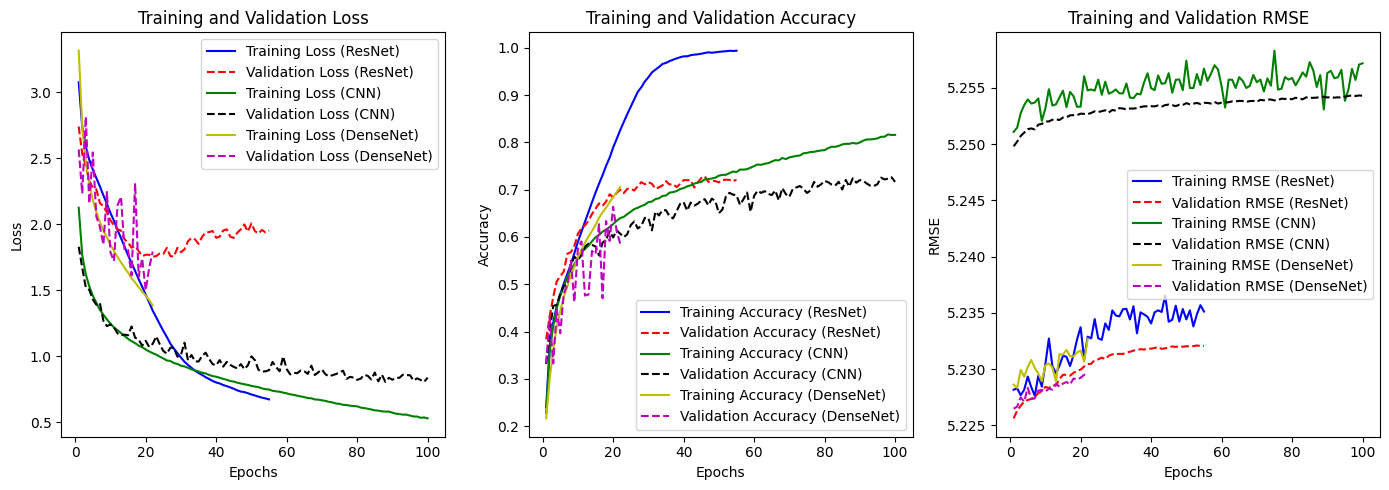

In [84]:
# Assuming you have the history object from model.fit
# Example: history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels))
import matplotlib.pyplot as plt

# Extracting metrics from the history object resnetv2
loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']
accuracy_resnet = history_resnet.history['accuracy']
val_accuracy_resnet = history_resnet.history['val_accuracy']
rmse_resnet = history_resnet.history['rmse']
val_rmse_resnet = history_resnet.history['val_rmse']


# Extracting metrics from the history object cnn
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']
accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']
rmse_cnn = history_cnn.history['rmse']
val_rmse_cnn = history_cnn.history['val_rmse']

# Extracting metrics from the history object densenet
loss_densenet = history_densenet.history['loss']
val_losss_densenet = history_densenet.history['val_loss']
accuracys_densenet = history_densenet.history['accuracy']
val_accuracys_densenet = history_densenet.history['val_accuracy']
rmses_densenet = history_densenet.history['rmse']
val_rmse_densenet = history_densenet.history['val_rmse']


# Number of epochs
epochs_resnet = range(1, len(loss_resnet) + 1)
epochs_cnn = range(1, len(loss_cnn) + 1)
epochs_densenet = range(1, len(loss_densenet) + 1)


# Plotting Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_resnet, loss_resnet, 'b-', label='Training Loss (ResNet)')
plt.plot(epochs_resnet, val_loss_resnet, 'r--', label='Validation Loss (ResNet)')
plt.plot(epochs_cnn, loss_cnn, 'g-', label='Training Loss (CNN)')
plt.plot(epochs_cnn, val_loss_cnn, 'k--', label='Validation Loss (CNN)')
plt.plot(epochs_densenet, loss_densenet, 'y-', label='Training Loss (DenseNet)')
plt.plot(epochs_densenet, val_losss_densenet, 'm--', label='Validation Loss (DenseNet)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_resnet, accuracy_resnet, 'b-', label='Training Accuracy (ResNet)')
plt.plot(epochs_resnet, val_accuracy_resnet, 'r--', label='Validation Accuracy (ResNet)')
plt.plot(epochs_cnn, accuracy_cnn, 'g-', label='Training Accuracy (CNN)')
plt.plot(epochs_cnn, val_accuracy_cnn, 'k--', label='Validation Accuracy (CNN)')
plt.plot(epochs_densenet, accuracys_densenet, 'y-', label='Training Accuracy (DenseNet)')
plt.plot(epochs_densenet, val_accuracys_densenet, 'm--', label='Validation Accuracy (DenseNet)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs_resnet, rmse_resnet, 'b-', label='Training RMSE (ResNet)')
plt.plot(epochs_resnet, val_rmse_resnet, 'r--', label='Validation RMSE (ResNet)')
plt.plot(epochs_cnn, rmse_cnn, 'g-', label='Training RMSE (CNN)')
plt.plot(epochs_cnn, val_rmse_cnn, 'k--', label='Validation RMSE (CNN)')
plt.plot(epochs_densenet, rmses_densenet, 'y-', label='Training RMSE (DenseNet)')
plt.plot(epochs_densenet, val_rmse_densenet, 'm--', label='Validation RMSE (DenseNet)')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
#pip install matplotlib
